# Predecting if patients will miss their scheduled appointments or not.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.

> Description of all features and the data itself is [here](https://www.kaggle.com/datasets/joniarroba/noshowappointments)

> Some of them:
* ‘ScheduledDay’ tells us on what day the patient set up their appointment.
* ‘Neighborhood’ indicates the location of the hospital.
* ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.  
* Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

### Question(s) for Analysis we need to answer.
* What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

1. Is there any relationship between showing up and the gender?
2. Is there any relationship between showing up and the age?
3. What is the most disease between **Hipertension** and **Diabetes** affect the absence of the patiente?
4. Is the location of the hospital affect the absence of the patients?


5. Is a certain range of ages are associated with the absence?
6. Do Receiving messages have an effect on comming to the appointment? 

In [719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [720]:
def PlotBars(label1, height1, label2, height2, col1='r', col2='b', Titel='Titel', yLabel='Number of patients', xLabel=''):
    sns.set()
    fig, ax = plt.subplots()
    ax.bar(label1, height1, label=label1, color=col1)
    ax.bar(label2, height2, label=label2, color=col2)
    ax.set_title(Titel)
    ax.set_ylabel(yLabel)
    ax.set_xlabel(xLabel)
    ax.legend()
def PlotPies(column, Labels, Title):
    sns.set()
    fig = plt.figure(figsize =(10, 7))
    plt.pie(df[column].value_counts().values, labels=Labels, colors=['#234E70', 'r'], autopct='%.0f%%', textprops={'color':"w"})
    plt.legend()
    plt.title(Title)
    plt.show()

<a id='wrangling'></a>
## Data Wrangling


### Assessing and Building Intuition

In [ ]:
df.shape

There are 14 columns and 110527 rows in the dataset.

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


> Notice: ScheduledDay & AppointmentDay are objects not DayTime.

In [241]:
# This shows the number of unique values in each column.
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

> * The number of unique appointments > patients .. thats mean many patients have more than one appointment.
>
> * There are 5 values in Handcap column, but it should be only 0 & 1.

In [297]:
# The Descriptive statistics for each column.
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


> * Avg age of the patients is 37 years old.
> * The oldest patient has 115 years old.
> * There are not many patients have Diabetes, Alcoholism or Handcap.
> * Less than the half of the sms messages are received.

In [298]:
# Number of null values.
df.isnull().sum().sum()

0

There is no null values in the dataset.

> Info about **Age** column.

Text(0, 0.5, 'Number of the patients')

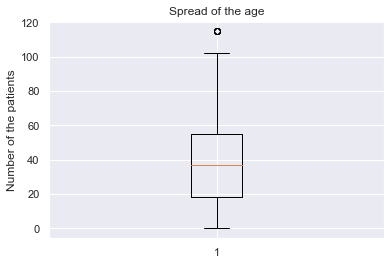

In [311]:
# Getting statistical informations about age column.
sns.set()
fig, ax = plt.subplots()
ax.boxplot(df['Age']);
ax.set_title('Spread of the age')
ax.set_ylabel('Number of the patients')

* There is an outlier when the patient has about 119 years old.

Text(0, 0.5, 'Number of patients')

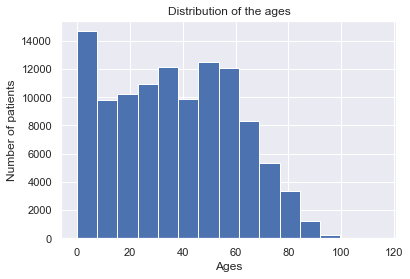

In [312]:
fig, ax = plt.subplots()
ax.hist(df['Age'], bins=15)
ax.set_xlabel("Ages")
ax.set_title('Distribution of the ages')
ax.set_ylabel('Number of patients')

`* The age state that has the maximum number of patients is Infants.

> Info about **Gender** column.

In [560]:
Data = df['Gender'].value_counts()
Data

F    71839
M    38687
Name: Gender, dtype: int64

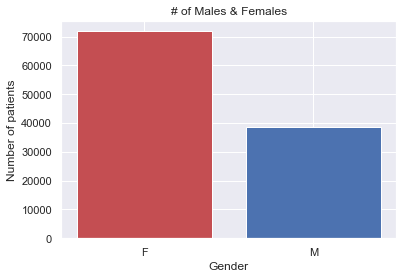

In [561]:
PlotBars(label1=Data.index[0], height1=Data.values[0], label2=Data.index[1], height2=Data.values[1], Titel='# of Males & Females', xLabel='Gender')

* There are more than 70,000 female patients.
* There are less than 40,000 male patients.
* There are a number of female patients about double the number of the male patients

Text(0, 0.5, 'Number of appointments')

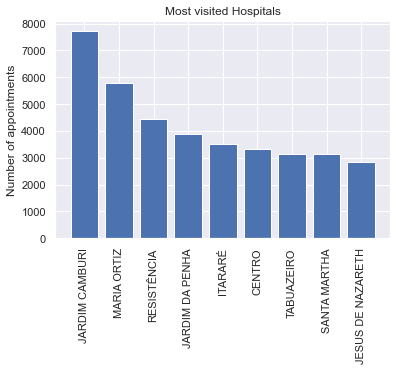

In [790]:
most_visited_hospitals = df.Neighbourhood.value_counts()[0: 9]
names = most_visited_hospitals.index
sns.set()
fig, ax = plt.subplots()
ax.bar(most_visited_hospitals.index, most_visited_hospitals.values);
plt.xticks(rotation=90);
ax.set_title('Most visited Hospitals')
ax.set_ylabel('Number of appointments')

> Info about **Scholarship** column.

In [562]:
Data = df['Scholarship'].value_counts()
Data

0    99665
1    10861
Name: Scholarship, dtype: int64

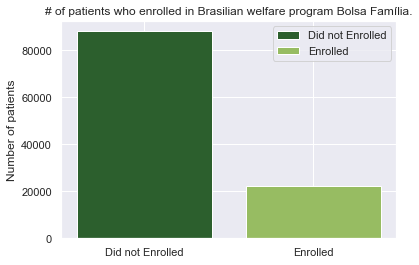

In [588]:
PlotBars(label1='Did not Enrolled', height1=Data.values[0], label2='Enrolled', height2=Data.values[1], Titel="# of patients who enrolled in Brasilian welfare program Bolsa Família.", col1='#2C5F2D', col2='#97BC62FF')

* There are about 100,000 patients who did not enrolled the Brasilian welfare praogram Bolsa Familia.
* There are about 10,000  patients who enrolled.

> Info about **Hipertension** column.

In [564]:
Data = df['Hipertension'].value_counts()
Data

0    88725
1    21801
Name: Hipertension, dtype: int64

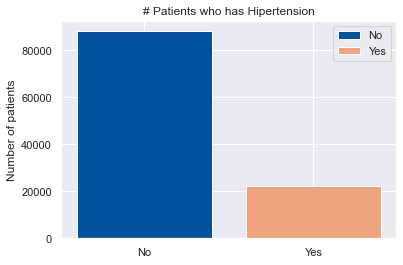

In [589]:
PlotBars(label1='No', height1=Data.values[0], label2='Yes', height2=Data.values[1], Titel="# Patients who has Hipertension", col1='#00539CFF', col2='#EEA47FFF')

* Most of patients does not have Hipertension.

> Info about **Diabetes** column.

In [590]:
Data = df['Diabetes'].value_counts()
Data

0    102583
1      7943
Name: Diabetes, dtype: int64

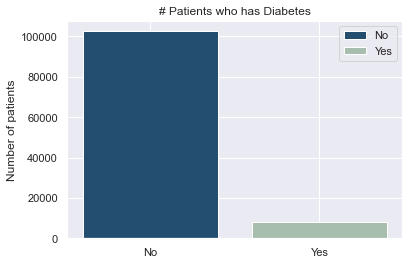

In [591]:
PlotBars(label1='No', height1=Data.values[0], label2='Yes', height2=Data.values[1], Titel="# Patients who has Diabetes", col1='#234E70', col2='#A7BEAE')

* About 102,000 patients do not have diabetes.
* Less than 10,000 patients do.

> Info about **Alcoholism** column.

In [592]:
Data = df['Alcoholism'].value_counts()
Data

0    107166
1      3360
Name: Alcoholism, dtype: int64

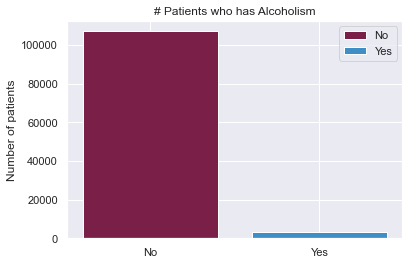

In [593]:
PlotBars(label1='No', height1=Data.values[0], label2='Yes', height2=Data.values[1], Titel="# Patients who has Alcoholism", col1='#7A2048', col2='#408EC6')

* About 107,000 patients do not have Alcoholism.
* Less than 3,500 patients do.

> Info about **SMS_received** column.

In [572]:
Data = df['SMS_received'].value_counts()
Data

0    75044
1    35482
Name: SMS_received, dtype: int64

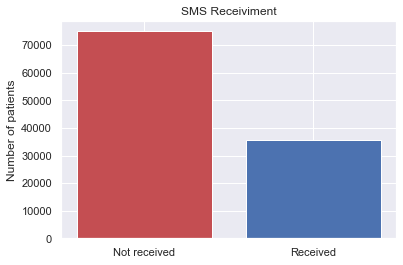

In [573]:
PlotBars(label1='Not received', height1=Data.values[0], label2='Received', height2=Data.values[1], Titel="SMS Receiviment")

> * More than 75,000 sms messages did not recieved.
> * About 35,000 sms messages recieved.

In [574]:
Data = df['No-show'].value_counts()
Data

No     88207
Yes    22319
Name: No-show, dtype: int64

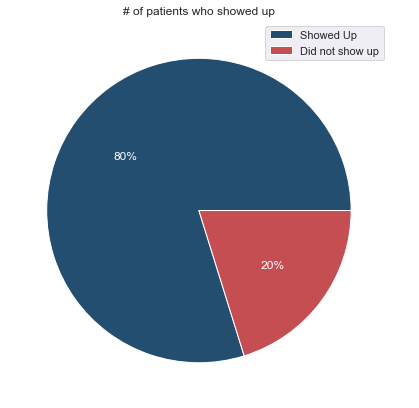

In [594]:
PlotPies(column='No-show', Labels=['Showed Up', 'Did not show up'], Title='# of patients who showed up')

* There are 80% of patients showed up.


### Data Cleaning

> Making the data type of **ScheduledDay & AppointmentDay** columns to be DateTime.

In [721]:
# Making the data type of ScheduledDay & AppointmentDay => DateTime data type.
# Then we save only the dates as all times on AppointmentDay are 0:0:0.

# converting column from object -> datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

# df['ScheduledDay'] = df['ScheduledDay'].dt.date

df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
# df['AppointmentDay'] = df['AppointmentDay'].dt.date

Text(0, 0.5, 'Number of appointments')

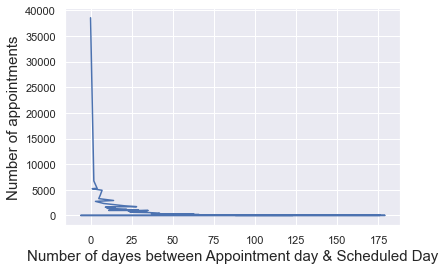

In [744]:
# calculating the difference between the 2 days using only dates not hours.
df['Waiting'] = df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date
df['Waiting'] = df.Waiting.dt.days


df.Waiting.value_counts().plot()
plt.xlabel('Number of dayes between Appointment day & Scheduled Day', fontsize=15)
plt.ylabel('Number of appointments', fontsize=15)

* Most appointments done in their sceduled days but there are few appointments that done after the sceduled day and befor it.

In [748]:
# making 2 columns for the days of the appointment day & sceduled day.
df['Appointment_Day'] = df.AppointmentDay.dt.day_name()
df['Scheduled_Day'] = df.ScheduledDay.dt.day_name()

> Cleaning and Editign **Age** column.

In [751]:
# Ignoring any invalid ages' rows.
df = df[df['Age'] >= 0]

> Cleaning and Editing **Handcap** column.

In [791]:
# Ignoring all values that not in [0, 1]
df['Handcap'] = df[df['Handcap'].isin([1, 0])]['Handcap']
df['Handcap'].value_counts()

0.0    108285
1.0      2042
Name: Handcap, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Replace this header name!)

In [750]:
df.groupby(['No-show', 'Gender'], as_index=False)['PatientId'].count()

,No-show,Gender,PatientId
0,No,F,57245
1,No,M,30962
2,Yes,F,14594
3,Yes,M,7725


### Research Question 2  (Replace this header name!)

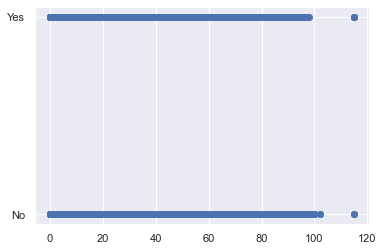

<a id='conclusions'></a>
## Conclusions